In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import subprocess


def get_git_root():
    """Get the root directory of the git repository"""
    try:
        git_root = (
            subprocess.check_output(
                ["git", "rev-parse", "--show-toplevel"], stderr=subprocess.DEVNULL
            )
            .strip()
            .decode("utf-8")
        )
        return git_root
    except (subprocess.CalledProcessError, FileNotFoundError):
        return None


# Change to git root
git_root = get_git_root()
if git_root:
    os.chdir(git_root)
    print(f"Changed to git root: {os.getcwd()}")
else:
    print("Not in a git repository or git not found")

Changed to git root: /Users/sherman/GitHub/CSE-6748


In [3]:
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
X_index = pd.read_parquet("data/cleaned/X_index.parquet")
X = pd.read_parquet("data/cleaned/X.parquet")
Y = pd.read_parquet("data/cleaned/Y.parquet")

In [5]:
# Train/test split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=69,
)

# Instantiate a CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=3000,
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    random_seed=42,
    verbose=100,
)

# Fit on training data
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

catboost_model.fit(
    X_train,
    Y_train,
    cat_features=categorical_features,
    eval_set=(X_valid, Y_valid),
    use_best_model=True,
)

0:	learn: 157.4521862	test: 161.5740938	best: 161.5740938 (0)	total: 73.9ms	remaining: 3m 41s
100:	learn: 96.5937824	test: 99.4642307	best: 99.4642307 (100)	total: 1.42s	remaining: 40.8s
200:	learn: 93.6193302	test: 97.0052217	best: 97.0052217 (200)	total: 2.66s	remaining: 37s
300:	learn: 92.3657631	test: 96.3285474	best: 96.3285474 (300)	total: 3.93s	remaining: 35.2s
400:	learn: 90.9841740	test: 95.8606138	best: 95.8606138 (400)	total: 5.19s	remaining: 33.6s
500:	learn: 89.7644767	test: 95.6387644	best: 95.6387644 (500)	total: 6.45s	remaining: 32.2s
600:	learn: 88.5972933	test: 95.4732853	best: 95.4706444 (598)	total: 7.73s	remaining: 30.9s
700:	learn: 87.5626759	test: 95.3351107	best: 95.3313550 (699)	total: 9.11s	remaining: 29.9s
800:	learn: 86.6053955	test: 95.2209694	best: 95.2209694 (800)	total: 10.4s	remaining: 28.4s
900:	learn: 85.6770882	test: 95.1813529	best: 95.1766454 (898)	total: 11.8s	remaining: 27.5s
1000:	learn: 84.7472648	test: 95.1834798	best: 95.1690394 (916)	total: 

In [ ]:
# Predict & evaluate
y_pred_cat = catboost_model.predict(X_valid)
rmse_cat = np.sqrt(mean_squared_error(Y_valid, y_pred_cat))
print(f"CatBoost RMSE on validation set: {rmse_cat:.4f}")

CatBoost RMSE on validation set: 67.2095


In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(
    {
        "sat_math_score": Y_valid["sat_math_score"],
        "sat_verbal_score": Y_valid["sat_verbal_score"],
        "pred_sat_math_score": y_pred_cat[:, 0],
        "pred_sat_verbal_score": y_pred_cat[:, 1],
    }
)

comparison_df

,sat_math_score,sat_verbal_score,pred_sat_math_score,pred_sat_verbal_score
4094,710,620,660.195325,670.271162
4168,450,580,479.679372,526.369471
6840,760,770,730.150117,734.607797
5654,470,450,410.576893,424.208936
4151,500,510,447.387308,457.739817
...,...,...,...,...
6945,390,430,416.754637,438.266389
3894,490,610,514.530284,523.090695
2666,410,520,431.865429,443.221809
4279,570,610,652.025393,617.997794


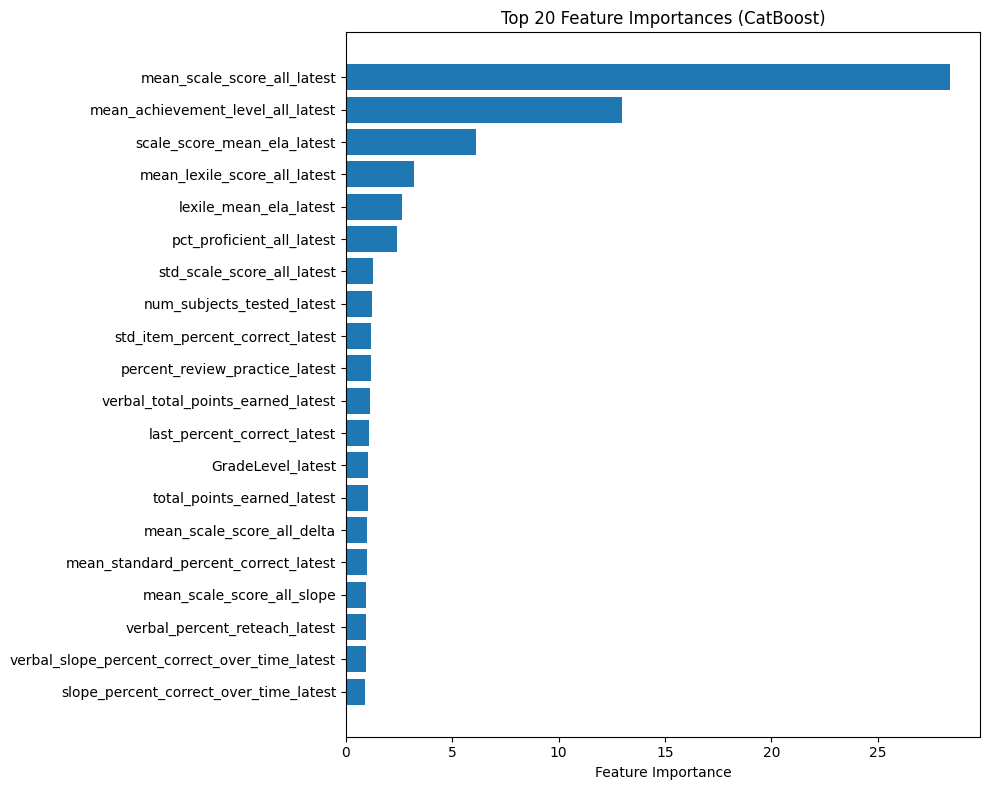

In [8]:
# Get feature importance (default is 'PredictionValuesChange')
feature_importance = catboost_model.get_feature_importance()

# Create a DataFrame for better visualization
feature_names = X.columns
importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (CatBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()